In [1]:
!pip install transformers
!pip install tokenizers
!pip install seqeval
!pip install pytorch-crf
from torchcrf import CRF
import torch
from transformers import BertModel, AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments, AdamW, BertConfig, get_linear_schedule_with_warmup, get_constant_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
log_soft = F.log_softmax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=b574e33b5be57410bc78e823ce880fb94ac946046ea59e207da1ee3f433ab701
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
MAX_LEN = 256
bs = 32

In [3]:
def read_conll_file(file_path):
    data = []
    current_sentence = []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            if line.startswith('-DOCSTART-'):
                continue
            if line:
                parts = line.split()
                word = parts[0]
                ner_label = parts[-1]
                current_sentence.append((word, ner_label))
            else:
                if current_sentence:
                    data.append(current_sentence)
                    current_sentence = []
    if current_sentence:
        data.append(current_sentence)
    return data

In [4]:
train_data = read_conll_file('/content/train_final.conll')
val_data = read_conll_file('/content/NER_Irish_validation.conll')
test_data = read_conll_file('/content/NER_Irish_test.conll')

In [5]:
# Finding instances of multi-word named entities

def findMWE(sentence):
    tags = [tag for _, tag in sentence]  # Extract only the tags

    # Condition 1: Sentence must contain at least one 'I-' tag
    if not any(tag.startswith('I-') for tag in tags):
        return False

    # Condition 2: Ensure all 'B-' tags are followed by an 'I-' tag
    prev_tag = None
    for tag in tags:
        if tag.startswith('B-'):
            prev_tag = tag  # Store current 'B-' tag
        elif tag.startswith('I-'):
            if prev_tag and prev_tag[2:] == tag[2:]:  # Matching entity type
                prev_tag = None  # Valid sequence, reset

    # If there's still a lingering 'B-' tag, it means it wasn't followed correctly
    return prev_tag is None


mwe_test_data = [sentence for sentence in test_data if findMWE(sentence)]
print(len(mwe_test_data))
print(mwe_test_data[:10])

89
[[('Mar', 'O'), ('a', 'O'), ('tchítear', 'O'), ('do', 'O'), ('Sheosamh', 'B-PER'), ('Mac', 'I-PER'), ('Grianna', 'I-PER'), ('é', 'O'), ('caithfidh', 'O'), ('an', 'O'), ('t-ealaíontóir', 'O'), ('an', 'O'), ('solas', 'O'), ('a', 'O'), ('thabhairt', 'O'), ('don', 'O'), ('saol', 'O'), ('agus', 'O'), ('diúltú', 'O'), ('do', 'O'), ('chathú', 'O'), ('sin', 'O'), ('na', 'O'), ('truaillíochta', 'O'), ('a', 'O'), ('chuireann', 'O'), ('an', 'O'), ('saol', 'O'), ('ina', 'O'), ('chosán', 'O'), ('.', 'O')], [('Grianghraif', 'O'), ('le', 'O'), ('Maidhc', 'B-PER'), ('Ó', 'I-PER'), ('Seachnasaí', 'I-PER'), ('.', 'O')], [('Tagann', 'O'), ('a', 'O'), ('ráiteas', 'O'), ('tar', 'O'), ('éis', 'O'), ('don', 'O'), ('chomhlacht', 'O'), ('a', 'O'), ('rá', 'O'), ('le', 'O'), ('hoibrithe', 'O'), ('an', 'O'), ('iarnróid', 'O'), ('mí', 'O'), ('ó', 'O'), ('shin', 'O'), ('go', 'O'), ('raibh', 'O'), ('sí', 'O'), ('le', 'O'), ('dúnadh', 'O'), (':', 'O'), ("'Chuamar", 'O'), ('ag', 'O'), ('cruinniú', 'O'), ('i', 'O'),

In [6]:
# Import tokenizer and create tag dictionary
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

tag_values = [
        'O',
        'B-PER',
        'I-PER',
        'B-LOC',
        'I-LOC',
        'B-ORG',
        'I-ORG'
]

tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [8]:
# Split the words and labels in the data
def splitWordsAndLabels(data_list):
  sent = []
  labels = []
  for lst in data_list:
    s = []
    l = []
    for words in lst:
      s.append(words[0])
      l.append(words[1])
    sent.append(s)
    labels.append(l)
  return sent, labels

train_sent, train_labels = splitWordsAndLabels(train_data)
val_sent, val_labels = splitWordsAndLabels(val_data)
test_sent, test_labels = splitWordsAndLabels(test_data)
mwe_test_sent, mwe_test_labels = splitWordsAndLabels(mwe_test_data)
print(train_sent[1])
print(train_labels[1])

['Baineann', 'mo', 'cheist', 'le', 'cúrsaí', 'tithíochta', 'i', 'nGaillimh', '-', 'tá', 'sé', 'níos', 'cirte', 'easpa', 'tithíochta', 'i', 'nGaillimh', 'a', 'rá', '-', 'agus', 'an', 'tascfhórsa', 'a', 'bunaíodh', 'breis', 'agus', 'ceithre', 'bliana', 'ó', 'shin']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [9]:
# Tokenize the data and preserve the corresponding labels/tags

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)
    return tokenized_sentence, labels

# Run the splitting function on the training, test, and validation sets
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(train_sent, train_labels)
]

val_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(val_sent, val_labels)
]

test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(test_sent, test_labels)
]

mwe_test_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(mwe_test_sent, mwe_test_labels)
]

# Bring the sentences and labels back together after tokenizing
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

val_tokenized_texts = [token_label_pair[0] for token_label_pair in val_tokenized_texts_and_labels]
val_labels = [token_label_pair[1] for token_label_pair in val_tokenized_texts_and_labels]

test_tokenized_texts = [token_label_pair[0] for token_label_pair in test_tokenized_texts_and_labels]
test_labels = [token_label_pair[1] for token_label_pair in test_tokenized_texts_and_labels]

mwe_test_tokenized_texts = [token_label_pair[0] for token_label_pair in mwe_test_tokenized_texts_and_labels]

print(tokenized_texts[1])
print(labels[1])

['Bai', '##nea', '##nn', 'mo', 'che', '##ist', 'le', 'c', '##úr', '##sa', '##í', 'ti', '##th', '##íocht', '##a', 'i', 'n', '##G', '##ail', '##lim', '##h', '-', 'tá', 'sé', 'níos', 'ci', '##rte', 'ea', '##sp', '##a', 'ti', '##th', '##íocht', '##a', 'i', 'n', '##G', '##ail', '##lim', '##h', 'a', 'rá', '-', 'agus', 'an', 'tas', '##c', '##f', '##h', '##ór', '##sa', 'a', 'buna', '##íodh', 'br', '##eis', 'agus', 'cei', '##th', '##re', 'bli', '##ana', 'ó', 'shi', '##n']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [10]:
# Get the input ids for each dataset
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

val_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in val_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

mwe_test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in mwe_test_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

# Get the tags for each dataset
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

val_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in val_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

mwe_test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in mwe_test_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

# Create attention masks for each dataset
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

val_attention_masks = [[float(i != 0.0) for i in ii] for ii in val_input_ids]

test_attention_masks = [[float(i != 0.0) for i in ii] for ii in test_input_ids]

mwe_test_attention_masks = [[float(i != 0.0) for i in ii] for ii in mwe_test_input_ids]

# Make the inputs, tags, and masks for each dataset into torch tensors
tr_inputs = torch.tensor(input_ids)
tr_tags = torch.tensor(tags)
tr_masks = torch.tensor(attention_masks)

vl_inputs = torch.tensor(val_input_ids)
vl_tags = torch.tensor(val_tags)
vl_masks = torch.tensor(val_attention_masks)

tst_inputs = torch.tensor(test_input_ids)
tst_tags = torch.tensor(test_tags)
tst_masks = torch.tensor(test_attention_masks)

mwe_tst_inputs = torch.tensor(mwe_test_input_ids)
mwe_tst_tags = torch.tensor(mwe_test_tags)
mwe_tst_masks = torch.tensor(mwe_test_attention_masks)

# Create a tensor dataset, sampler and dataloader for each dataset
tr_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(tr_data) # Sample from the training set randomly
train_dataloader = DataLoader(tr_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(vl_inputs, vl_masks, vl_tags)
valid_sampler = SequentialSampler(valid_data) # Sample from the validation set sequentially
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

tst_data = TensorDataset(tst_inputs, tst_masks, tst_tags)
tst_sampler = SequentialSampler(tst_data) # Sample from the test set sequentially
tst_dataloader = DataLoader(tst_data, sampler=tst_sampler, batch_size=bs)

mwe_tst_data = TensorDataset(mwe_tst_inputs, mwe_tst_masks, mwe_tst_tags)
mwe_sampler = SequentialSampler(mwe_tst_data) # Sample from the mwe test set sequentially
mwe_tst_dataloader = DataLoader(mwe_tst_data, sampler=mwe_sampler, batch_size=bs)

In [11]:
# Load the model
config = BertConfig.from_pretrained('bert-base-multilingual-cased', output_hidden_states=True)
config.max_position_embeddings = 512

bert_model = BertModel.from_pretrained(
                        'bert-base-multilingual-cased',
                        config=config,
                        add_pooling_layer=False
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [12]:
class BERT_CRF(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BERT_CRF, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.25)
        # 4 last of layer
        self.classifier = nn.Linear(4*768, num_labels)
        self.crf = CRF(num_labels, batch_first = True)

    def forward_custom(self, b_input_ids, b_input_mask,  b_labels=None, token_type_ids=None):
        outputs = self.bert(b_input_ids, attention_mask=b_input_mask)
        sequence_output = torch.cat((outputs[1][-1], outputs[1][-2], outputs[1][-3], outputs[1][-4]),-1)
        sequence_output = self.dropout(sequence_output)

        emission = self.classifier(sequence_output)

        if b_labels is not None:
            loss = -self.crf(log_soft(emission, 2), b_labels, mask=b_input_mask.type(torch.uint8), reduction='mean')
            prediction = self.crf.decode(emission, mask=b_input_mask.type(torch.uint8))
            return [loss, prediction]

        else:
            prediction = self.crf.decode(emission, mask=b_input_mask.type(torch.uint8))
            return prediction

In [13]:
model = BERT_CRF(bert_model, num_labels=len(tag2idx))
model.to(device)

BERT_CRF(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [14]:
model.cuda();

In [15]:
# Optimising parameters for finetuning the model
cnt = -1
num_layer = 197
for param in model.named_parameters():
    cnt += 1
    if cnt>=num_layer:
        param[1].requires_grad = True
    else:
        param[1].requires_grad = True
    print(cnt,param[0],'\t',param[1].requires_grad)


FINETUNING = True
if FINETUNING:
    param_optimizer1 = list(model.named_parameters())[:num_layer]
    param_optimizer2 = list(model.named_parameters())[num_layer:num_layer+2]
    param_optimizer3 = list(model.named_parameters())[num_layer+2:]
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer1 if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 1e-5},
        {'params': [p for n, p in param_optimizer1 if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0},

        {'params': [p for n, p in param_optimizer2 if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 1e-3,
         'lr': 1e-3},
        {'params': [p for n, p in param_optimizer2 if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0,
         'lr':1e-3},

        {'params': [p for n, p in param_optimizer3 if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 1e-3,
         'lr':4e-3},
        {'params': [p for n, p in param_optimizer3 if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0,
         'lr':4e-3}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

epochs = 10
max_grad_norm = 1.0

# Total number of training steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# Defining the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps/10),
    num_training_steps=total_steps
)

0 bert.embeddings.word_embeddings.weight 	 True
1 bert.embeddings.position_embeddings.weight 	 True
2 bert.embeddings.token_type_embeddings.weight 	 True
3 bert.embeddings.LayerNorm.weight 	 True
4 bert.embeddings.LayerNorm.bias 	 True
5 bert.encoder.layer.0.attention.self.query.weight 	 True
6 bert.encoder.layer.0.attention.self.query.bias 	 True
7 bert.encoder.layer.0.attention.self.key.weight 	 True
8 bert.encoder.layer.0.attention.self.key.bias 	 True
9 bert.encoder.layer.0.attention.self.value.weight 	 True
10 bert.encoder.layer.0.attention.self.value.bias 	 True
11 bert.encoder.layer.0.attention.output.dense.weight 	 True
12 bert.encoder.layer.0.attention.output.dense.bias 	 True
13 bert.encoder.layer.0.attention.output.LayerNorm.weight 	 True
14 bert.encoder.layer.0.attention.output.LayerNorm.bias 	 True
15 bert.encoder.layer.0.intermediate.dense.weight 	 True
16 bert.encoder.layer.0.intermediate.dense.bias 	 True
17 bert.encoder.layer.0.output.dense.weight 	 True
18 bert.encode

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
## Store the average loss after each epoch so we can plot them
loss_values, validation_loss_values = [], []
best_model_state = None
patience = 2
best_val_loss = float('inf')
epochs_without_improvement = 0
best_epoch = 0

for epoch in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set

    # Put the model into training mode
    model.train()
    # Reset the total loss for this epoch
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`
        outputs = model.forward_custom(b_input_ids, b_input_mask, b_labels, token_type_ids=None)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            # This will return the logits rather than the loss because we have not provided labels
            outputs = model.forward_custom(b_input_ids, b_input_mask, b_labels, token_type_ids=None)
        # Move logits and labels to CPU
        logits = outputs[0].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend(outputs[1])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = []
    valid_tags = []
    for p, l in zip(predictions, true_labels):
        for p_i, l_i in zip(p, l):
            if tag_values[l_i] != "PAD":
                pred_tags.append(tag_values[p_i])
                valid_tags.append(tag_values[l_i])
                tokens = tokenizer.convert_ids_to_tokens(b_input_ids[0].to('cpu').numpy())
                new_tokens, new_labels, new_preds = [], [], []
                for token, label_idx, pred in zip(tokens, l, p):
                    if token.startswith("##"):
                        new_tokens[-1] = new_tokens[-1] + token[2:]
                    else:
                        new_labels.append(label_idx)
                        new_preds.append(pred)
                        new_tokens.append(token)
                for token, pred, label in zip(new_tokens, new_preds, new_labels):
                    pred_tags.append(tag_values[pred])
                    valid_tags.append(tag_values[label])

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    val_report = classification_report(valid_tags, pred_tags)
    print("Epoch {} - Validation Classification Report:".format(epoch))
    print(val_report)
    if eval_loss < best_val_loss:
      best_val_loss = eval_loss
      best_epoch = epoch
      best_model_state = model.state_dict()
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
          print(f"Validation loss hasn't improved for {patience} epochs. Best model found at epoch {best_epoch}.")
          break

    print("Epoch {} - Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch, avg_train_loss, eval_loss))
    print()

# Output the best epoch model
if best_model_state is not None:
    torch.save(best_model_state, "mBERT_CRF.pt")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


Average train loss: 60.1343309879303
Validation loss: 16.458165407180786
Validation Accuracy: 0.8872491431427175


Epoch:  10%|█         | 1/10 [00:57<08:36, 57.36s/it]

Epoch 0 - Validation Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.62      0.72      0.67      6172
       B-ORG       0.51      0.67      0.58      9833
       B-PER       0.57      0.31      0.40      6642
       I-LOC       0.64      0.87      0.73      2562
       I-ORG       0.41      0.69      0.51     10228
       I-PER       0.60      0.28      0.39     12156
           O       0.97      0.96      0.97    220538

    accuracy                           0.89    268131
   macro avg       0.62      0.64      0.61    268131
weighted avg       0.90      0.89      0.89    268131

Epoch 0 - Training Loss: 60.1343, Validation Loss: 16.4582

Average train loss: 15.077305093407631
Validation loss: 11.663695335388184
Validation Accuracy: 0.9144634525660964


Epoch:  20%|██        | 2/10 [01:51<07:24, 55.62s/it]

Epoch 1 - Validation Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.71      0.82      0.76      6172
       B-ORG       0.52      0.82      0.64      9833
       B-PER       0.66      0.37      0.48      6642
       I-LOC       0.85      0.68      0.76      2562
       I-ORG       0.54      0.90      0.68     10228
       I-PER       0.86      0.47      0.60     12156
           O       0.99      0.97      0.98    220538

    accuracy                           0.91    268131
   macro avg       0.73      0.72      0.70    268131
weighted avg       0.93      0.91      0.92    268131

Epoch 1 - Training Loss: 15.0773, Validation Loss: 11.6637

Average train loss: 9.030004695057869
Validation loss: 11.438742399215698
Validation Accuracy: 0.9200838396157103


Epoch:  30%|███       | 3/10 [02:47<06:29, 55.61s/it]

Epoch 2 - Validation Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.82      0.92      0.87      6172
       B-ORG       0.70      0.52      0.60      9833
       B-PER       0.58      0.78      0.66      6642
       I-LOC       0.87      0.84      0.85      2562
       I-ORG       0.54      0.77      0.64     10228
       I-PER       0.68      0.55      0.61     12156
           O       0.98      0.97      0.98    220538

    accuracy                           0.92    268131
   macro avg       0.74      0.76      0.74    268131
weighted avg       0.93      0.92      0.92    268131

Epoch 2 - Training Loss: 9.0300, Validation Loss: 11.4387

Average train loss: 5.872654937207699
Validation loss: 11.318814039230347
Validation Accuracy: 0.9204306850009883


Epoch:  40%|████      | 4/10 [03:43<05:33, 55.65s/it]

Epoch 3 - Validation Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.87      0.82      0.84      6172
       B-ORG       0.56      0.73      0.63      9833
       B-PER       0.61      0.43      0.50      6642
       I-LOC       0.91      0.89      0.90      2562
       I-ORG       0.53      0.86      0.66     10228
       I-PER       0.84      0.49      0.62     12156
           O       0.98      0.97      0.98    220538

    accuracy                           0.92    268131
   macro avg       0.76      0.74      0.73    268131
weighted avg       0.93      0.92      0.92    268131

Epoch 3 - Training Loss: 5.8727, Validation Loss: 11.3188

Average train loss: 4.154253888875246
Validation loss: 11.834690570831299
Validation Accuracy: 0.9225565115559186


Epoch:  50%|█████     | 5/10 [04:38<04:38, 55.67s/it]

Epoch 4 - Validation Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.78      0.94      0.85      6172
       B-ORG       0.59      0.79      0.67      9833
       B-PER       0.70      0.47      0.56      6642
       I-LOC       0.62      0.95      0.75      2562
       I-ORG       0.52      0.87      0.65     10228
       I-PER       0.92      0.46      0.62     12156
           O       0.99      0.97      0.98    220538

    accuracy                           0.92    268131
   macro avg       0.73      0.78      0.73    268131
weighted avg       0.94      0.92      0.92    268131

Epoch 4 - Training Loss: 4.1543, Validation Loss: 11.8347

Average train loss: 2.5876408517360687
Validation loss: 12.172084093093872
Validation Accuracy: 0.9284603421461898


Epoch:  50%|█████     | 5/10 [05:34<05:34, 66.86s/it]

Epoch 5 - Validation Classification Report:
              precision    recall  f1-score   support

       B-LOC       0.90      0.92      0.91      6172
       B-ORG       0.60      0.80      0.69      9833
       B-PER       0.65      0.44      0.53      6642
       I-LOC       0.87      0.93      0.90      2562
       I-ORG       0.53      0.91      0.67     10228
       I-PER       0.87      0.48      0.61     12156
           O       0.99      0.97      0.98    220538

    accuracy                           0.93    268131
   macro avg       0.77      0.78      0.76    268131
weighted avg       0.94      0.93      0.93    268131

Validation loss hasn't improved for 2 epochs. Best model found at epoch 3.


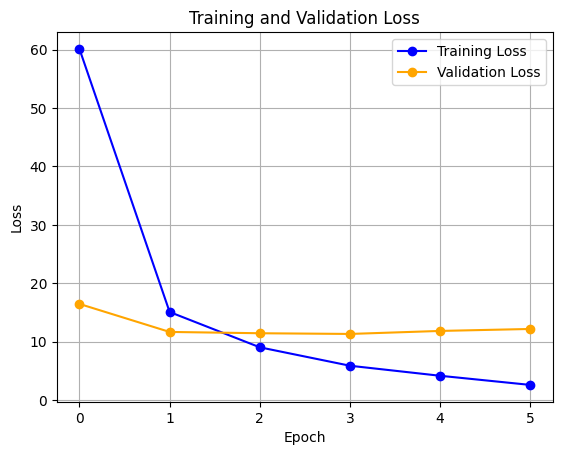

In [17]:
# Training and Validation Loss Plot

# Generate x-axis values (epochs)
epochs = range(len(loss_values) + 1)

# Plotting with markers and lines
plt.plot(epochs[:-1], loss_values, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(epochs[:-1], validation_loss_values, marker='o', linestyle='-', label='Validation Loss', color='orange')

# Labeling and styling
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Set ticks for x-axis (epochs) to whole numbers only starting from 0
plt.xticks(epochs[:-1])


# Ensure y-axis (loss) ticks are whole numbers only
#plt.yticks(range(int(min(min(loss_values), min(validation_loss_values))), int(max(max(loss_values), max(validation_loss_values))) + 1))
plt.savefig('mbert_CRF_training_validation_loss_plot.png')
# Show plot
plt.grid(True)
plt.show()

In [18]:
model.eval()

predicted_labels = []
true_labels = []

# Iterate through the test_dataloader to get the predictions
# Using the GPU
for batch in tst_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        #outputs = model(**inputs)
        outputs = model.forward_custom(batch[0], batch[1], batch[2], token_type_ids=None)

    # Extracting the predictions and also the true labels for the test data
    predict_labels = outputs[1]
    #print(predict_labels)
    predictions = []
    for predict_label in predict_labels:
      #print(predict_label)
      predicted_labels.append(predict_label)
    #predicted_labels.append(predictions)

    true_labels.extend(inputs['labels'].tolist())

In [19]:
trues = []

for sentences in true_labels:
  t = []
  for vals in sentences:
    if vals != 7:
      t.append(vals)
  trues.append(t)

preds=predicted_labels

In [20]:
i = 0
while i < len(preds):
  if len(test_labels[i]) != len(preds[i]):
    print(f'issue: {i} {len(test_labels[i])}, {len(preds[i])}')
    print(f'{test_tokenized_texts[i]}\n{test_labels[i]}\n{preds[i]}')
    i += 1
  i += 1

In [21]:
label_map = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-LOC',
    4: 'I-LOC',
    5: 'B-ORG',
    6: 'I-ORG'
}

# Initialise an empty list to store DataFrames
dfs = []

# Iterate through the tokens, labels, and predictions
for tokens, labels, predictions in zip(test_tokenized_texts, test_labels, preds):
    # Create a DataFrame from the current sublist
    temp_df = pd.DataFrame({'Word': tokens, 'POS': 'X', 'True': labels, 'Predicted': [label_map[pred] for pred in predictions]})
    # Append the DataFrame to the list
    dfs.append(temp_df)
    # Add an empty row as a DataFrame to the list
    dfs.append(pd.DataFrame({'Word': [''], 'POS': [''], 'True': [''], 'Predicted': ['']}))

# Concatenate the DataFrames along the rows axis
df = pd.concat(dfs, ignore_index=True)

# Print the concatenated DataFrame
print(df)

# Check the alignment is correct
print(df.head(45))

        Word POS   True Predicted
0        Mar   X      O         O
1          a   X      O         O
2          t   X      O         O
3       ##ch   X      O         O
4       ##ít   X      O         O
...      ...  ..    ...       ...
7930      Ga   X  B-LOC     B-LOC
7931  ##elta   X  B-LOC     B-LOC
7932   ##cht   X  B-LOC     B-LOC
7933     ann   X      O         O
7934                             

[7935 rows x 4 columns]
      Word POS   True Predicted
0      Mar   X      O         O
1        a   X      O         O
2        t   X      O         O
3     ##ch   X      O         O
4     ##ít   X      O         O
5    ##ear   X      O         O
6       do   X      O         O
7      She   X  B-PER     B-PER
8    ##osa   X  B-PER     B-PER
9     ##mh   X  B-PER     B-PER
10     Mac   X  I-PER     I-PER
11       G   X  I-PER     I-PER
12  ##rian   X  I-PER     I-PER
13    ##na   X  I-PER     I-PER
14       é   X      O         O
15     cai   X      O         O
16    ##th   X      O  

In [22]:
# Change to conll format for evaluation script to be run
conll_format = ""

for index, row in df.iterrows():
    text = row['Word']
    pos = row['POS']
    tag = row['True']
    mapped_tag = row['Predicted']

    # Append the token in CoNLL format (word, POS, gold_label, predicted_label)
    conll_format += f"{text}\t{pos}\t{tag}\t{mapped_tag}\n"

# Write the CoNLL format string to a text file
with open('mBERT_CRF.conll', 'w') as f:
    f.write(conll_format)

#MWE case study

In [23]:
model.eval()

mwe_predicted_labels = []
mwe_true_labels = []

# Iterate through the test_dataloader to get the predictions
# Using the GPU
for batch in mwe_tst_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

    # Disabling gradient calculation for evaluation
    with torch.no_grad():
        #outputs = model(**inputs)
        outputs = model.forward_custom(batch[0], batch[1], batch[2], token_type_ids=None)

    # Extracting the predictions and also the true labels for the test data
    predict_labels = outputs[1]
    #print(predict_labels)
    predictions = []
    for predict_label in predict_labels:
      #print(predict_label)
      mwe_predicted_labels.append(predict_label)
    #predicted_labels.append(predictions)

    mwe_true_labels.extend(inputs['labels'].tolist())

In [24]:
#print(mwe_predicted_labels)

In [25]:
print(len(mwe_predicted_labels))
print(len(mwe_true_labels))

89
89


In [26]:
print(mwe_true_labels[0])
print(mwe_predicted_labels[0])

[0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
mwe_preds = []
mwe_trues = []

for sentences in mwe_true_labels:
  t = []
  for vals in sentences:
    if vals != 7:
      t.append(vals)
  mwe_trues.append(t)

for sentences in mwe_predicted_labels:
  p = []
  for vals in sentences:
    if vals != 7:
      p.append(vals)
  mwe_preds.append(p)


#print(mwe_test_tokenized_texts_and_labels)
mwe_tokenized_labels = []
for sentence, labels in mwe_test_tokenized_texts_and_labels:
    mwe_tokenized_labels.append(labels)

print(len(mwe_test_tokenized_texts[0]))
print(len(mwe_trues[0]))
print(len(mwe_tokenized_labels[0]))
print(len(mwe_preds[0]))

65
31
65
65


In [28]:
i = 0
while i < len(mwe_tokenized_labels):
  #print(len(mwe_true_labels[i]))
  #print(len(mwe_predicted_labels[i]))
  #print(i)
  if len(mwe_tokenized_labels[i]) != len(mwe_preds[i]):
    print('issue')
    i += 1
  i += 1

In [29]:
# Initialise an empty list to store DataFrames
dfs = []

# Iterate through the tokens, labels, and predictions
for tokens, labels, predictions in zip(mwe_test_tokenized_texts, mwe_tokenized_labels, mwe_preds):
    # Create a DataFrame from the current sublist
    temp_df = pd.DataFrame({'Word': tokens, 'POS': 'X', 'True': labels, 'Predicted': [label_map[pred] for pred in predictions]})
    # Append the DataFrame to the list
    dfs.append(temp_df)
    # Add an empty row as a DataFrame to the list
    dfs.append(pd.DataFrame({'Word': [''], 'POS': [''], 'True': [''], 'Predicted': ['']}))

# Concatenate the DataFrames along the rows axis
df = pd.concat(dfs, ignore_index=True)

# Print the concatenated DataFrame
print(df)

# Check the alignment is correct
print(df.head(45))

       Word POS   True Predicted
0       Mar   X      O         O
1         a   X      O         O
2         t   X      O         O
3      ##ch   X      O         O
4      ##ít   X      O         O
...     ...  ..    ...       ...
5095    ##D   X  I-LOC     I-LOC
5096  ##éis   X  I-LOC     I-LOC
5097    ##e   X  I-LOC     I-LOC
5098      .   X      O         O
5099                            

[5100 rows x 4 columns]
      Word POS   True Predicted
0      Mar   X      O         O
1        a   X      O         O
2        t   X      O         O
3     ##ch   X      O         O
4     ##ít   X      O         O
5    ##ear   X      O         O
6       do   X      O         O
7      She   X  B-PER     B-PER
8    ##osa   X  B-PER     B-PER
9     ##mh   X  B-PER     B-PER
10     Mac   X  I-PER     I-PER
11       G   X  I-PER     I-PER
12  ##rian   X  I-PER     I-PER
13    ##na   X  I-PER     I-PER
14       é   X      O         O
15     cai   X      O         O
16    ##th   X      O         O
17 

In [30]:
# Change to conll format for evaluation script to be run
conll_format = ""

for index, row in df.iterrows():
    text = row['Word']
    pos = row['POS']
    tag = row['True']
    mapped_tag = row['Predicted']

    # Append the token in CoNLL format (word, POS, gold_label, predicted_label)
    conll_format += f"{text}\t{pos}\t{tag}\t{mapped_tag}\n"

# Write the CoNLL format string to a text file
with open('mBERT_CRF_MWE.conll', 'w') as f:
    f.write(conll_format)